In [1]:
import optuna

In [9]:
import pandas as pd
import numpy as np
# Load the dataset
file_path = "data_12k_10c.csv"
data = pd.read_csv(file_path)

# Display dataset information and the first few rows for inspection
data.info(), data.head()
data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119808 entries, 0 to 119807
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   de_normal    119808 non-null  float64
 1   de_7_inner   119808 non-null  float64
 2   de_7_ball    119808 non-null  float64
 3   de_7_outer   119808 non-null  float64
 4   de_14_inner  119808 non-null  float64
 5   de_14_ball   119808 non-null  float64
 6   de_14_outer  119808 non-null  float64
 7   de_21_inner  119808 non-null  float64
 8   de_21_ball   119808 non-null  float64
 9   de_21_outer  119808 non-null  float64
dtypes: float64(10)
memory usage: 9.1 MB


RangeIndex(start=0, stop=119808, step=1)

de_normal: Normal bearing data.
de_7_inner, de_7_ball, de_7_outer: Fault data for a 7-mil defect at inner race, ball, and outer race.
de_14_inner, de_14_ball, de_14_outer: Fault data for a 14-mil defect.
de_21_inner, de_21_ball, de_21_outer: Fault data for a 21-mil defect.

In [3]:
data_head = data.head(10000)
feature_id = [i for i in range(len(data.columns))]
data_head.columns = feature_id
data_reform = pd.melt(data_head.reset_index(), id_vars=["index"], var_name="id", value_name="Value")[["id", "Value"]]
labels = [i * np.ones(len(data_head)) for i in range(len(data.columns))] # 0 as normal, 1 as abnormal
data_reform['label'] = pd.DataFrame(np.concatenate(labels), columns=["Label"])
Time = np.array(data.index / 12000) # 12k frequency
data_reform['time'] = pd.DataFrame(np.tile(Time, 10), columns=["Time"])
data_reform['kind'] = 'de'
data_reform = data_reform[['id', 'time', 'kind', 'Value', 'label']]
data_reform

,id,time,kind,Value,label
0,0,0.000000,de,0.053197,0.0
1,0,0.000083,de,0.088662,0.0
2,0,0.000167,de,0.099718,0.0
3,0,0.000250,de,0.058621,0.0
4,0,0.000333,de,-0.004590,0.0
...,...,...,...,...,...
99995,9,8.332917,de,0.133603,9.0
99996,9,8.333000,de,-0.023147,9.0
99997,9,8.333083,de,-0.091776,9.0
99998,9,8.333167,de,0.023553,9.0


In [32]:
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series, impute
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

extracted_features = extract_features(
    data_reform,
    column_id="id",
    column_kind='kind',
    column_sort="time",  
    column_value="Value",  
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=10)

impute(extracted_features)
extracted_features

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]
C:\Users\s5575\miniconda3\envs\general\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['de__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,de__variance_larger_than_standard_deviation,de__has_duplicate_max,de__has_duplicate_min,de__has_duplicate,de__sum_values,de__abs_energy,de__mean_abs_change,de__mean_change,de__mean_second_derivative_central,de__median,...,de__fourier_entropy__bins_5,de__fourier_entropy__bins_10,de__fourier_entropy__bins_100,de__permutation_entropy__dimension_3__tau_1,de__permutation_entropy__dimension_4__tau_1,de__permutation_entropy__dimension_5__tau_1,de__permutation_entropy__dimension_6__tau_1,de__permutation_entropy__dimension_7__tau_1,de__query_similarity_count__query_None__threshold_0.0,de__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,116.781849,55.418910,0.030396,-7.281405e-06,-0.000004,0.012100,...,0.136002,0.273489,0.983872,1.387006,2.176709,3.035001,3.941518,4.872200,0.0,0.244855
1,0.0,0.0,0.0,1.0,152.055038,838.102722,0.273840,-6.920429e-06,0.000013,0.007797,...,0.717240,1.075393,2.602407,1.751731,2.913647,4.332951,5.829394,7.294991,0.0,1.461313
2,0.0,0.0,0.0,1.0,152.864289,189.672225,0.155932,1.835701e-06,0.000009,0.015919,...,0.371882,0.699121,1.694475,1.756227,2.681042,3.904211,5.174910,6.414573,0.0,0.491413
3,0.0,0.0,0.0,1.0,340.271546,4617.105215,0.614196,1.227320e-04,-0.000049,0.029644,...,0.484652,0.726496,1.375694,1.760703,2.785309,4.061948,5.364411,6.575808,0.0,3.313503
4,0.0,0.0,0.0,1.0,493.517558,432.124683,0.165083,4.459290e-05,0.000020,0.049543,...,0.776087,1.043657,2.482774,1.767991,2.909649,4.303626,5.765994,7.202295,0.0,1.755599
5,0.0,0.0,0.0,1.0,50.705100,341.507238,0.168429,4.600623e-05,-0.000004,0.005198,...,0.470510,0.823230,1.859344,1.749104,2.758212,4.066770,5.441980,6.786542,0.0,1.365151
6,0.0,0.0,0.0,1.0,188.638478,111.047378,0.121709,7.389721e-07,0.000006,0.017275,...,0.265376,0.509081,2.046141,1.778980,2.962154,4.355873,5.828868,7.257562,0.0,0.385747
7,0.0,0.0,0.0,1.0,197.629949,2656.142270,0.477387,-2.011554e-04,0.000032,0.013807,...,0.536753,0.670173,1.519545,1.734920,2.598636,3.795798,5.080094,6.326505,0.0,2.994260
8,0.0,0.0,0.0,1.0,184.344055,135.384380,0.126057,-1.575778e-06,-0.000001,0.016244,...,0.327050,0.636860,2.008111,1.760503,2.827878,4.175347,5.602570,6.987689,0.0,0.477699
9,0.0,0.0,0.0,1.0,58.117665,3513.289340,0.393901,-2.323055e-05,-0.000003,0.005482,...,0.569834,0.853526,1.935054,1.748299,2.877055,4.266043,5.738258,7.194400,0.0,5.343884


In [ ]:
from tsfresh.feature_selection import significance_tests
from statsmodels.stats.multitest import multipletests

extracted_features = extracted_features.dropna(axis=1)
p_values = []

for col in extracted_features.columns:
    x = pd.Series(extracted_features.loc[:,col])
    y = pd.Series(np.array(data.columns))
    p_value = significance_tests.target_real_feature_real_test(x, y)
    p_values.append([col, p_value])

filtered_p_values = [row for row in p_values if not np.isnan(row[1])]
sorted_p_values = sorted(filtered_p_values, key=lambda x: x[1])
df_pvalues = pd.DataFrame(sorted_p_values, columns=['feature', 'value'])
df_pvalues

In [49]:
reject, pvals_corrected, _, _ = multipletests(df_pvalues['value'].values, alpha=0.05, method='fdr_by')

results = pd.DataFrame({
    'feature': df_pvalues['feature'],
    'p_value': df_pvalues['value'].values,
    'p_value_corrected': pvals_corrected,
    'reject_null': reject
}).set_index('feature')

# Sort features by corrected p-value in ascending order
results_sorted = results.sort_values('p_value_corrected')

# Select the top 10 features
top_10_features = results_sorted.sort_values(by='p_value_corrected', ascending=False).head(100)
top_10_features

,p_value,p_value_corrected,reject_null
feature,,,
"de__fft_coefficient__attr_""abs""__coeff_90",0.009491,1.0,False
"de__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)",0.015737,1.0,False
"de__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)",0.025347,1.0,False
"de__fft_coefficient__attr_""real""__coeff_65",0.025347,1.0,False
"de__fft_coefficient__attr_""imag""__coeff_14",0.025347,1.0,False
...,...,...,...
"de__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)",0.179712,1.0,False
de__ar_coefficient__coeff_8__k_10,0.179712,1.0,False
de__ar_coefficient__coeff_10__k_10,0.179712,1.0,False


In [5]:
import pandas as pd
import numpy as np

# Create a DataFrame with numeric column IDs
data_head = pd.DataFrame(data.values, columns=range(data.shape[1]))

# Reshape the data into a long format
data_reform2 = pd.melt(
    data_head.reset_index(), 
    id_vars="index", 
    var_name="id", 
    value_name="Value"
)[["id", "Value"]]

labels = np.concatenate([np.full(len(data_head), i) for i in range(data.shape[1])])
data_reform2['label'] = labels.astype(str)
Time = data.index / 12000.0
data_reform2['time'] = np.tile(Time, data.shape[1])
data_reform2['kind'] = 'de'
data_reform2 = data_reform2[['id', 'time', 'kind', 'Value', 'label']]

data_reform2

,id,time,kind,Value,label
0,0,0.000000,de,0.053197,0
1,0,0.000083,de,0.088662,0
2,0,0.000167,de,0.099718,0
3,0,0.000250,de,0.058621,0
4,0,0.000333,de,-0.004590,0
...,...,...,...,...,...
1198075,9,9.983583,de,-0.024365,9
1198076,9,9.983667,de,-0.044264,9
1198077,9,9.983750,de,0.042639,9
1198078,9,9.983833,de,-0.059289,9


In [80]:
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series, impute
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

num_chunks = 1198
chunked_data = []

for curr_id, group in data_reform2.groupby('id'):
    group = group.sort_values('time')  # ensure sorted by time
    n = len(group)
    chunk_size = n // num_chunks

    for i in range(num_chunks):
        start = i * chunk_size
        end = (i+1)*chunk_size if i < num_chunks - 1 else n
        chunk_group = group.iloc[start:end].copy()

        if len(chunk_group) > 0:
            chunk_group['chunk_id'] = f"{curr_id}_chunk_{i+1}"
            chunked_data.append(chunk_group)

chunked_df = pd.concat(chunked_data, ignore_index=True)

df = extract_features(chunked_df,
                     column_id="chunk_id",
                     column_kind='kind',
                     column_sort="time",  
                     column_value="Value",  
                     default_fc_parameters=EfficientFCParameters(),
                     impute_function=impute)

df = df.fillna(0)
print(df.head(3))

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [03:47<00:00,  5.70s/it]


             de__variance_larger_than_standard_deviation  \
0_chunk_1                                            0.0   
0_chunk_10                                           0.0   
0_chunk_100                                          0.0   

             de__has_duplicate_max  de__has_duplicate_min  de__has_duplicate  \
0_chunk_1                      0.0                    0.0                1.0   
0_chunk_10                     0.0                    0.0                1.0   
0_chunk_100                    0.0                    0.0                1.0   

             de__sum_values  de__abs_energy  de__mean_abs_change  \
0_chunk_1          1.769684        0.670941             0.032036   
0_chunk_10         0.579951        0.945475             0.043055   
0_chunk_100        0.409929        0.332876             0.020312   

             de__mean_change  de__mean_second_derivative_central  de__median  \
0_chunk_1           0.000457                           -0.000367    0.033066   
0_chu

In [118]:
from tsfresh import extract_features, extract_relevant_features, select_features

label = df.index.str[0]
df_extracted = copy.deepcopy(df)
df_extracted = df_extracted.apply(pd.to_numeric, errors='coerce')
df_extracted = df_extracted.dropna(axis=1, how='all')
df_extracted = df_extracted.reset_index(drop=True)
y = np.array(label.values)

X_full_train, X_full_test, y_train, y_test = train_test_split(df_extracted, y, test_size=.4, random_state=42)
X_filtered_train = select_features(X_full_train, y_train)

In [145]:
df_all = df_extracted.loc[:, X_filtered_train.columns[:400]]
df_all['label'] = label
df_all

,"de__fft_aggregated__aggtype_""kurtosis""","de__fft_coefficient__attr_""abs""__coeff_27","de__fft_coefficient__attr_""abs""__coeff_26","de__fft_coefficient__attr_""abs""__coeff_25","de__fft_coefficient__attr_""abs""__coeff_24","de__fft_coefficient__attr_""abs""__coeff_23","de__fft_coefficient__attr_""abs""__coeff_22","de__fft_coefficient__attr_""abs""__coeff_21","de__fft_coefficient__attr_""abs""__coeff_12","de__linear_trend__attr_""stderr""",...,"de__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","de__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)","de__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)","de__linear_trend__attr_""slope""","de__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","de__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","de__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","de__fft_coefficient__attr_""real""__coeff_1","de__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)",label
0,12.328425,0.047333,0.074092,0.098484,0.093768,0.101217,0.113602,0.193483,0.115316,0.000278,...,-0.001831,-0.085429,-0.107072,-0.000359,0.053100,-0.040154,0.143239,-1.050552,-0.013273,0
1,12.805007,0.098620,0.086914,0.141272,0.082173,0.057214,0.110519,0.050076,0.365619,0.000330,...,-0.004038,0.064971,0.047282,-0.000804,-0.027507,0.004838,-0.172535,1.428617,-0.046455,0
2,7.823479,0.074154,0.120459,0.025656,0.163958,0.087475,0.127055,0.088048,0.367548,0.000200,...,0.001302,0.161553,0.060684,0.000255,0.084807,0.196767,-0.018408,-0.456805,0.160941,0
3,12.105983,0.018356,0.058031,0.106355,0.084731,0.073803,0.171638,0.106923,0.421915,0.000245,...,0.001705,-0.123773,-0.020577,0.000338,-0.093591,-0.126187,-0.075086,-1.288050,-0.109401,0
4,13.034902,0.082677,0.087605,0.059998,0.045335,0.105997,0.057692,0.074206,0.466557,0.000228,...,-0.000550,0.029732,0.035662,-0.000108,-0.005994,0.037507,0.161854,0.070428,0.025710,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,23.787703,0.919085,1.296054,1.285436,3.500123,5.053660,2.937438,1.906619,1.807821,0.000698,...,-0.000134,0.022297,-0.089913,-0.000022,0.220936,0.005365,-0.045744,0.445535,0.089710,9
11976,117.662191,6.806174,0.670549,2.195632,6.787525,8.922974,5.942809,5.852953,2.484037,0.001256,...,-0.000120,0.000567,0.200638,-0.000059,-0.158652,0.048042,-0.114512,-0.753245,-0.027393,9
11977,115.172457,9.614981,5.399246,7.457327,23.669586,30.177955,19.698485,12.763807,1.680207,0.003696,...,-0.001975,-0.010116,-0.025181,-0.000251,0.061086,0.055210,0.110419,-0.240997,0.051409,9
11978,59.164477,4.856639,4.917615,2.349001,5.405442,9.344628,5.645380,8.631949,2.636061,0.001272,...,0.000661,0.043060,0.626937,0.000061,-0.366720,0.241139,0.042057,0.744100,0.052392,9


In [ ]:
# Feature selection method 1
import copy
from tsfresh.feature_selection import significance_tests
from statsmodels.stats.multitest import multipletests

# label = df.index.str[0]
# df_extracted = copy.deepcopy(df)
# df_extracted = df_extracted.dropna(axis=1, how='all')
# df_extracted = df_extracted.reset_index(drop=True)
# df_extracted['label'] = label
p_values = []

for col in df_extracted.columns[:-1]:
    x = pd.Series(df_extracted.loc[:,col])
    y = pd.Series(np.array(label.values).astype(int))
    p_value = significance_tests.target_real_feature_real_test(x, y)
    p_values.append([col, p_value])

sorted_p_values = sorted(p_values, key=lambda x: x[1])
df_pvalues = pd.DataFrame(sorted_p_values, columns=['feature', 'value']).dropna().sort_values(by='value')
df_pvalues

In [143]:
top10_features = df_pvalues['feature'].head(250)
df_all = df_extracted.loc[:, top10_features]
df_all['label'] = label
df_all

,de__ar_coefficient__coeff_9__k_10,"de__fft_coefficient__attr_""abs""__coeff_26","de__fft_coefficient__attr_""abs""__coeff_4","de__fft_coefficient__attr_""abs""__coeff_9","de__fft_coefficient__attr_""abs""__coeff_35","de__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","de__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""",de__autocorrelation__lag_4,de__ar_coefficient__coeff_8__k_10,"de__fft_coefficient__attr_""abs""__coeff_5",...,"de__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)",de__energy_ratio_by_chunks__num_segments_10__segment_focus_6,"de__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.4",de__mean,"de__fft_coefficient__attr_""real""__coeff_0",de__sum_values,"de__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",de__autocorrelation__lag_6,"de__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""",label
0,1.244145,0.074092,0.430826,2.542803,0.027976,7.101520e-01,-1.112275,-0.144491,-1.439944,0.326621,...,-0.066058,0.151882,0.000634,0.017697,1.769684,1.769684,-0.078957,-0.448712,-0.001831,0
1,1.002732,0.086914,0.191478,5.492958,0.078926,6.335231e-01,-1.290465,-0.286863,-1.091480,0.527738,...,0.312320,0.053703,0.003081,0.005800,0.579951,0.579951,0.042928,-0.603270,-0.004038,0
2,1.353316,0.120459,1.035727,0.827547,0.029888,3.512752e-01,-1.859649,0.613063,-1.826725,0.330610,...,-0.057112,0.087828,-0.000471,0.004099,0.409929,0.409929,0.165776,0.604911,0.001302,0
3,0.842037,0.058031,0.297549,4.199068,0.031146,3.365563e-02,-3.013468,-0.444422,-1.174642,0.419901,...,-0.089823,0.119299,0.009796,0.019910,1.991025,1.991025,-0.124524,-0.728735,0.001705,0
4,1.178803,0.087605,0.157624,3.696067,0.083815,4.235607e-04,-4.311923,-0.431531,-1.360082,0.765143,...,0.021036,0.086337,0.005732,0.011144,1.114423,1.114423,0.029077,-0.723184,-0.000550,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,0.847830,1.296054,3.212629,0.307904,0.505592,6.469903e-09,-6.608374,0.389648,-1.439562,8.683372,...,0.041901,0.176509,-0.007411,0.005507,0.550655,0.550655,0.014649,-0.292754,-0.000134,9
11976,0.289646,0.670549,0.867701,1.089168,1.217226,7.583972e-03,-3.516065,0.518685,-0.374039,1.590692,...,-0.030787,0.127153,0.006188,0.000625,0.062538,0.062538,-0.005344,-0.273438,-0.000120,9
11977,0.456443,5.399246,10.364431,2.741695,2.476460,5.399039e-07,-5.770769,0.653515,-1.010872,13.123018,...,0.083321,0.257690,-0.007627,0.007846,0.784562,0.784562,0.020570,-0.372120,-0.001975,9
11978,0.167675,4.917615,1.083768,1.362342,0.838456,4.072947e-08,-6.267824,0.554085,-0.584682,11.460079,...,0.133078,0.042864,0.045950,0.006680,0.668014,0.668014,0.063823,-0.325684,0.000661,9


In [66]:
# Feature selection method 2
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy='mean')
# imputed_features = imputer.fit_transform(df)

# selector = SelectKBest(score_func=f_classif, k=10)
# selected_features = selector.fit_transform(imputed_features, y)

# # Get the names of the selected features
# selected_feature_mask = selector.get_support()
# selected_feature_names = df.columns[selected_feature_mask]
# print(selected_feature_names)

Index(['de__longest_strike_below_mean', 'de__autocorrelation__lag_2',
       'de__autocorrelation__lag_3', 'de__autocorrelation__lag_4',
       'de__autocorrelation__lag_5', 'de__autocorrelation__lag_6',
       'de__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'de__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'de__fourier_entropy__bins_10', 'de__fourier_entropy__bins_100'],
      dtype='object')


C:\Users\s5575\miniconda3\envs\general\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  1   2  44  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  69  70  71  72  73  74  75  76  77  78  79  80  81  82  91
 104 120 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 553 554 555 556 557 558 559 560 561 562 563 564 619 620 621 622
 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640
 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 6

In [ ]:
# df_all = df_extracted.loc[:, selected_feature_names]
# df_all['label'] = label
# df_all

Accuracy: 0.9828881469115192
Precision: 0.9832936909683474
Recall: 0.9828881469115192
F1-score: 0.9828756963942378


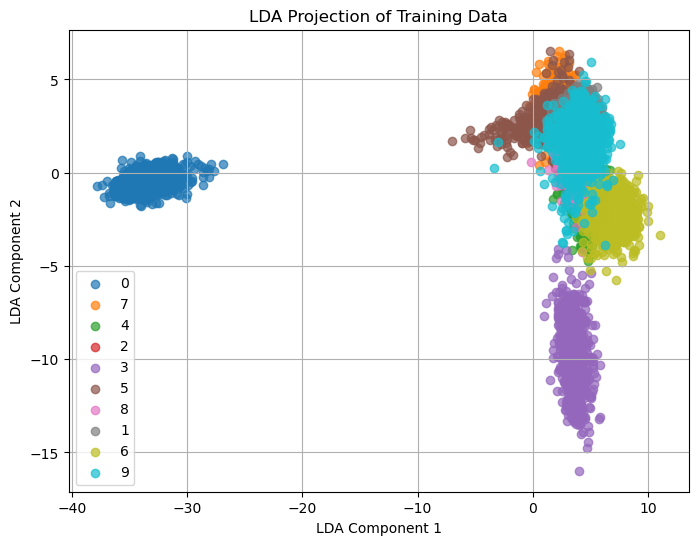

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

scaler = StandardScaler()
features = [col for col in df_all.columns if col not in ['label']]
X = df_all[features]
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
df_X = pd.DataFrame(X_std, columns=features)
y = df_all['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform LDA, aiming for 2 components for visualization
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Predict on the test set
y_pred = lda.predict(X_test)

# Compute classification metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

# Visualize the LDA projection using a scatter plot
# We'll plot the training data, color-coded by the label
plt.figure(figsize=(8,6))
for lbl in y_train.unique():
    mask = (y_train == lbl)
    plt.scatter(X_train_lda[mask, 0], X_train_lda[mask, 1], label=str(lbl), alpha=0.7)

plt.title("LDA Projection of Training Data")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [151]:
df_all.to_csv('extracted_features.csv', index=False)

In [ ]:
from pycaret.classification import setup, compare_models

# Combine the training and testing data for PyCaret's setup
X_train['target'] = y_train  # Add the target column to the training data
X_test['target'] = y_test    # Add the target column to the testing data

# Combine training and testing sets (PyCaret handles splitting internally if needed)
combined_data = pd.concat([X_train, X_test], axis=0)

# Initialize PyCaret classification setup
clf_setup = setup(
    data=combined_data,
    target='target',  # Specify the target column
    silent=True,      # Suppress interactive prompts
    session_id=42     # For reproducibility
)

# Compare models
best_model = compare_models()

print("Best model identified by PyCaret:", best_model)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Labels (ensure they are correctly aligned with the features)
labels = data_reform['label'].iloc[::len(np.unique(data_reform["time"]))]  # Extract one label per ID

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    extracted_features, labels, test_size=0.3, random_state=42, stratify=labels
)

# Initialize and fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = lda.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define segment size (e.g., 1000 samples per segment)
segment_size = 1000

# Normalize data across each column
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Segment the normalized data
segments = []
labels = []

for col in data.columns:
    for i in range(0, len(data), segment_size):
        if i + segment_size <= len(data):
            segments.append(normalized_data[i:i + segment_size, data.columns.get_loc(col)])
            labels.append(col)  # Assign the column name as the label

# Convert to numpy arrays for model input
segments = np.array(segments)
labels = np.array(labels)

# Check the shape of the segmented data
segments.shape, labels.shape


((1190, 1000), (1190,))

Preprocessing Results

Segments: The dataset has been divided into 1,190 segments of 1,000 samples each.
Labels: Each segment is labeled based on its corresponding fault type (e.g., de_normal, de_7_inner).

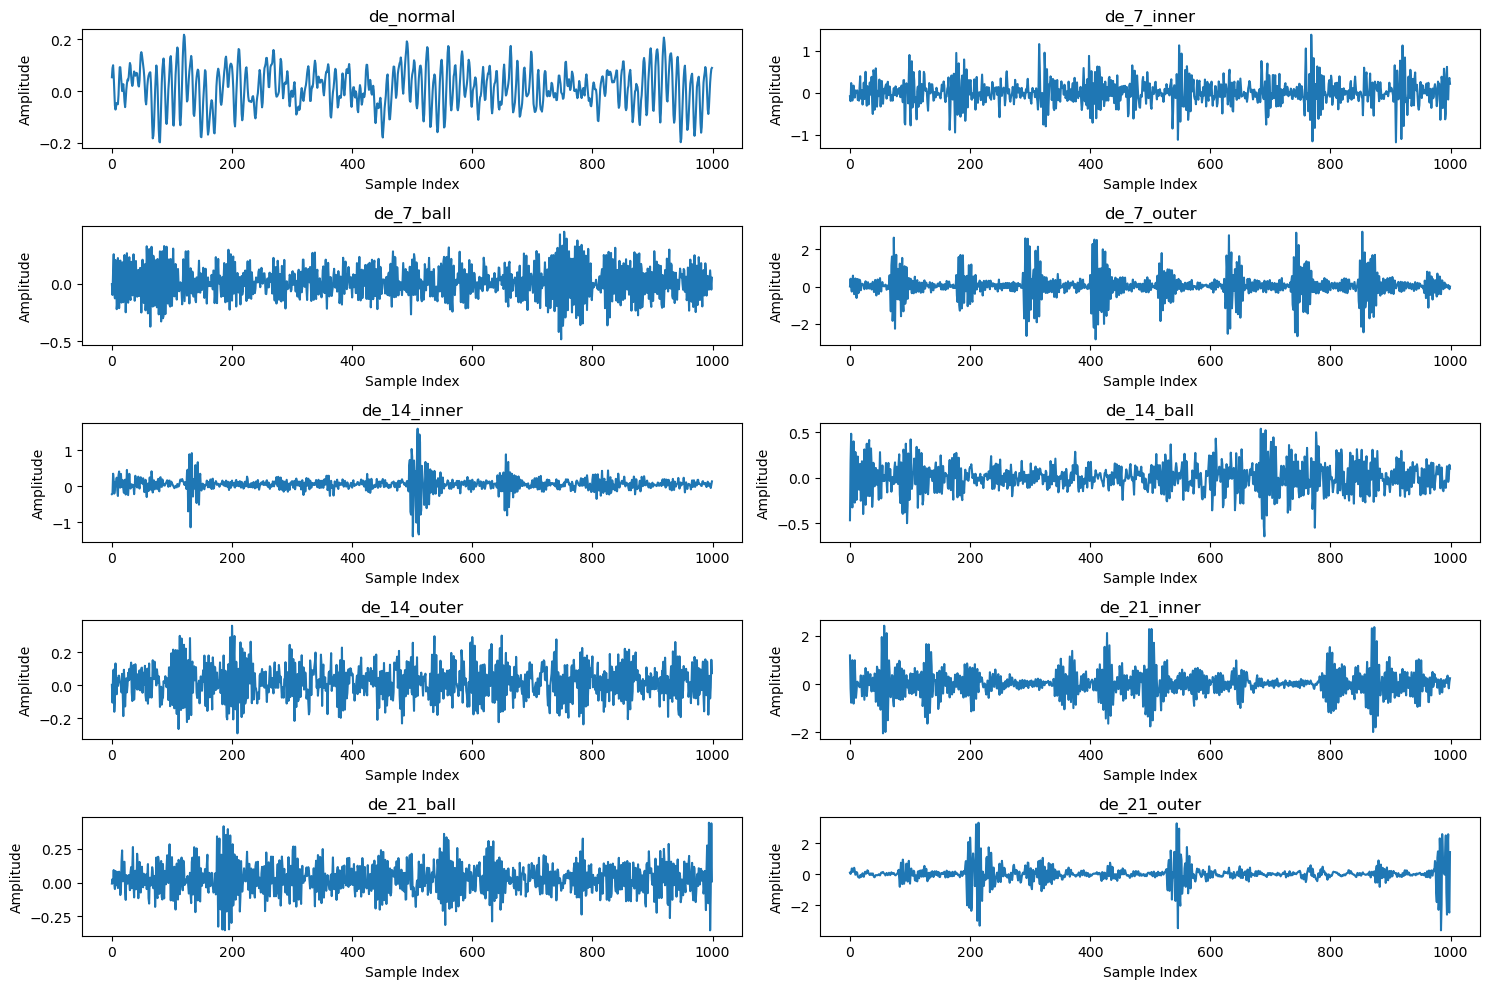

In [3]:
import matplotlib.pyplot as plt

# Plot a sample of vibration data from each column for visualization
plt.figure(figsize=(15, 10))
columns_to_plot = data.columns
for i, col in enumerate(columns_to_plot):
    plt.subplot(5, 2, i + 1)
    plt.plot(data[col][:1000])  # Plot the first 1000 samples
    plt.title(col)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.savefig('raw_data.png', dpi=300)
plt.show()


Normal vs Fault:
de_normal appears relatively stable compared to other columns, indicating minimal vibrations typical of normal bearing conditions.

Fault Types:
Vibration amplitudes vary significantly across fault types (e.g., de_7_inner, de_14_outer).
Larger defects (de_21_*) exhibit higher amplitudes and more pronounced patterns.

Segmentation and Normalization 

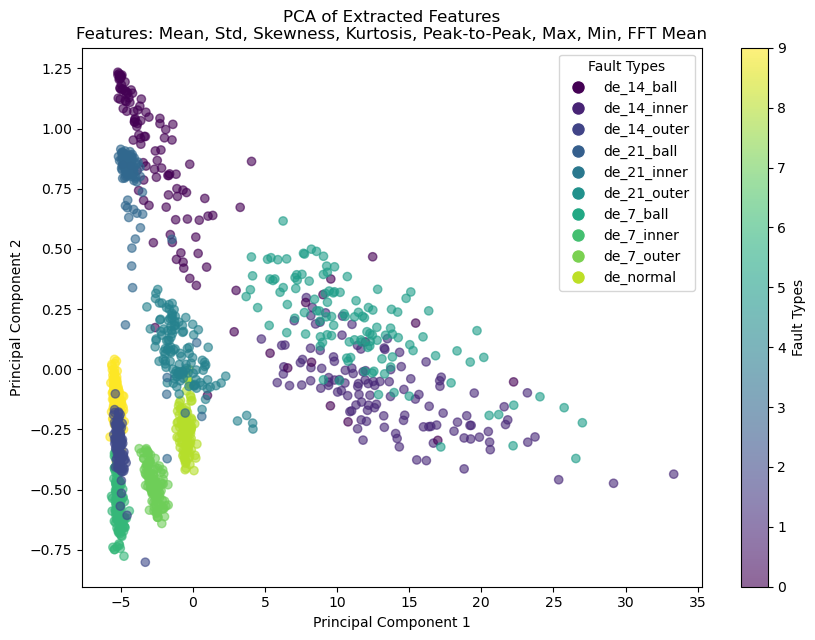

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Function to extract features from each segment
def extract_features(segments):
    features = []
    for segment in segments:
        # Statistical features
        mean = np.mean(segment)
        std = np.std(segment)
        skewness = skew(segment)
        kurt = kurtosis(segment)
        
        # Peak features
        peak_to_peak = np.ptp(segment)
        max_val = np.max(segment)
        min_val = np.min(segment)
        
        # Frequency domain feature (FFT)
        fft_vals = np.abs(np.fft.fft(segment))
        fft_mean = np.mean(fft_vals)
        
        # Concatenate all features into a single vector
        features.append([mean, std, skewness, kurt, peak_to_peak, max_val, min_val, fft_mean])
    
    return np.array(features)

# Apply the function to the segments
X_features = extract_features(segments)

# Label Encoding for plotting
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_reduced = pca.fit_transform(X_features)

# Visualize the 2D PCA projection with labeled color bar
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_encoded, cmap='viridis', alpha=0.6)

# Add color bar with corresponding labels
plt.colorbar(scatter, label='Fault Types')

# Add features description in title
plt.title('PCA of Extracted Features\nFeatures: Mean, Std, Skewness, Kurtosis, Peak-to-Peak, Max, Min, FFT Mean')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a custom legend for each fault type (color)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(i / len(label_encoder.classes_)), markersize=10) for i in range(len(label_encoder.classes_))]
plt.legend(handles=handles, labels=[str(label) for label in label_encoder.classes_], title="Fault Types", loc="best")
# plt.savefig('PCA.png', dpi=300)
# Display the plot
plt.show()


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

def objective(trial):
    param = {
        'objective': 'multi:softmax',
        'num_class': 10,  
        'max_depth': trial.suggest_int('max_depth', 2, 10),  
        'learning_rate': trial.suggest_categorical(
        'learning_rate', [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]),
        'gamma': trial.suggest_float('gamma', 0.1, 1000.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1000.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1000.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0, step=0.5),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
    }

    # cross-validation
    xgb_model = xgb.XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')

    return cv_accuracy.mean()

# Activate for model optimization
# import optuna
# study_name = f'120124_model-opt_7'
# storage_name = f'sqlite:///{study_name}.db'
# study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=False,)
# study.optimize(objective, n_trials=1024)

In [ ]:
# Get all trial results
trials_df = study.trials_dataframe()

# Rank models
trials_df['cv_accuracy'] = trials_df['value']
top_trials = trials_df.sort_values('cv_accuracy', ascending=False).head(5)
top_trials

# Extract the top 5 models
top_models = []
for index, row in top_trials.iterrows():
    params = study.trials[int(row['number'])].params
    params['objective'] = 'multi:softmax'
    params['num_class'] = 10
    params['use_label_encoder'] = False
    params['eval_metric'] = 'mlogloss'
    params.pop('accuracy', None)
    
    # Create and fit the model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    top_models.append(('xgb_model_' + str(index), model))

top_models

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

ensemble_xgb = VotingClassifier(estimators=top_models, n_jobs=-1)
ensemble_xgb.fit(X_train, y_train)


y_pred = ensemble_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"f1_score: {f1_score:.4f}")

# Show the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Testing Accuracy: 0.8739
Precision: 0.8822
Recall: 0.8739
f1_score: 0.8756
Confusion Matrix:
[[32  2  0  1  0  1  0  0  0  0]
 [ 0 28  0  0  0  7  0  0  0  0]
 [ 0  0 32  0  0  0  1  0  0  3]
 [ 0  0  0 34  1  0  0  0  1  0]
 [ 0  0  0  1 34  0  0  0  1  0]
 [ 0  9  0  0  0 26  0  0  0  0]
 [ 0  0  5  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  1  2  0  0  1 31  0]
 [ 0  0  8  0  0  0  0  0  0 28]]


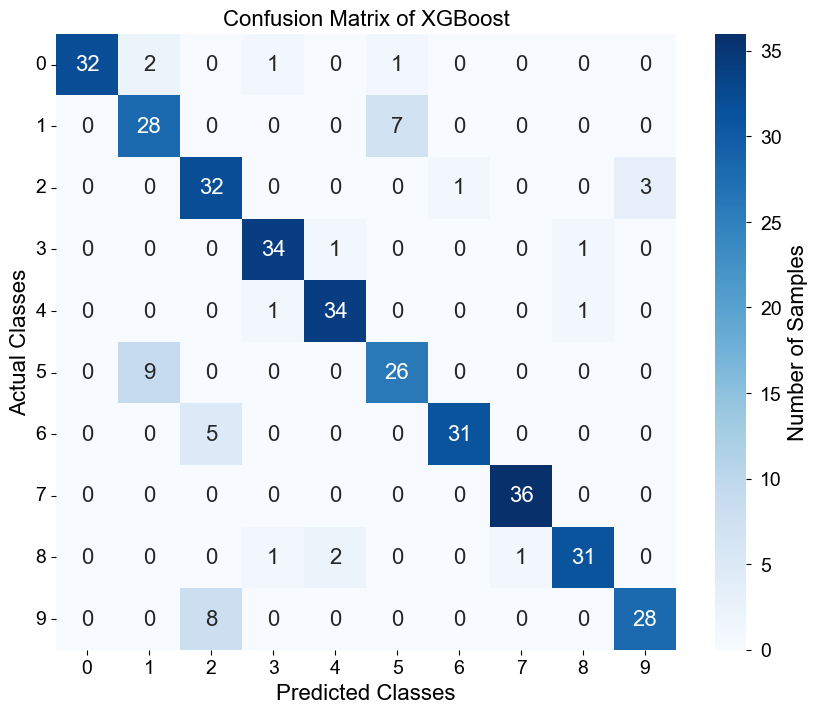

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
cf = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
ax.set_title('Confusion Matrix of XGBoost', fontsize=16)
ax.set_xlabel('Predicted Classes', fontsize=16)
ax.set_ylabel('Actual Classes', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
cbar = cf.collections[0].colorbar
cbar.ax.tick_params(labelsize=14, pad=7)
cbar.set_label('Number of Samples', size=16)
plt.savefig('xgb_confusion.png', dpi=300)
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

file_path = "extracted_features.csv"
df_all = pd.read_csv(file_path)
scaler = StandardScaler()
features = [col for col in df_all.columns if col not in ['label']]
X = df_all[features]
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
df_X = pd.DataFrame(X_std, columns=features)
y = df_all['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
from pycaret.classification import setup, compare_models

# Combine the training and testing data for PyCaret's setup
X_train['target'] = y_train  # Add the target column to the training data
X_test['target'] = y_test    # Add the target column to the testing data

# Combine training and testing sets (PyCaret handles splitting internally if needed)
combined_data = pd.concat([X_train, X_test], axis=0)

# Initialize PyCaret classification setup
clf_setup = setup(
    data=combined_data,
    target='target',  # Specify the target column
    session_id=42     # For reproducibility
)

# Compare models
best_model = compare_models()

print("Best model identified by PyCaret:", best_model)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(11980, 401)"
4,Transformed data shape,"(11980, 401)"
5,Transformed train set shape,"(8386, 401)"
6,Transformed test set shape,"(3594, 401)"
7,Numeric features,400
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9888,0.0000,0.9888,0.9889,0.9888,0.9875,0.9876,4.1190
gbc,Gradient Boosting Classifier,0.9840,0.0000,0.9840,0.9842,0.9840,0.9822,0.9823,69.6180
rf,Random Forest Classifier,0.9825,0.0000,0.9825,0.9826,0.9824,0.9805,0.9805,0.7100
lda,Linear Discriminant Analysis,0.9793,0.0000,0.9793,0.9798,0.9792,0.9769,0.9770,0.0650
et,Extra Trees Classifier,0.9784,0.0000,0.9784,0.9788,0.9783,0.9760,0.9761,0.1440
ridge,Ridge Classifier,0.9714,0.0000,0.9714,0.9720,0.9711,0.9682,0.9683,0.0340
dt,Decision Tree Classifier,0.9401,0.0000,0.9401,0.9406,0.9401,0.9335,0.9335,0.3780
lr,Logistic Regression,0.9279,0.0000,0.9279,0.9285,0.9278,0.9198,0.9199,2.6850
nb,Naive Bayes,0.8610,0.0000,0.8610,0.8682,0.8571,0.8455,0.8470,0.0360
svm,SVM - Linear Kernel,0.5763,0.0000,0.5763,0.6058,0.5708,0.5292,0.5337,0.0830


Best model identified by PyCaret: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9857,0.0000,0.9857,0.9857,0.9856,0.9841,0.9841
1,0.9893,0.0000,0.9893,0.9894,0.9892,0.9881,0.9881
2,0.9845,0.0000,0.9845,0.9845,0.9844,0.9828,0.9828
3,0.9797,0.0000,0.9797,0.9798,0.9797,0.9775,0.9775
4,0.9738,0.0000,0.9738,0.9740,0.9737,0.9709,0.9709
5,0.9857,0.0000,0.9857,0.9858,0.9856,0.9841,0.9841
6,0.9809,0.0000,0.9809,0.9812,0.9809,0.9788,0.9788
7,0.9785,0.0000,0.9785,0.9788,0.9786,0.9761,0.9762
8,0.9821,0.0000,0.9821,0.9821,0.9820,0.9801,0.9801


Random Forest model created: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


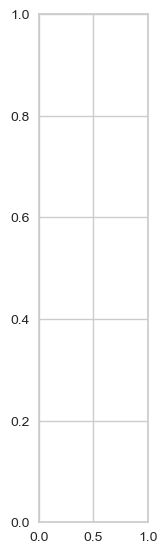

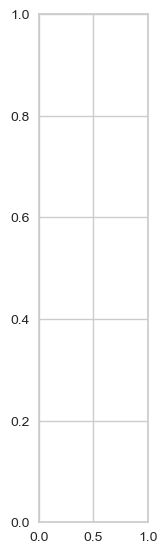

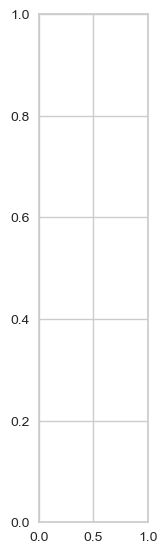

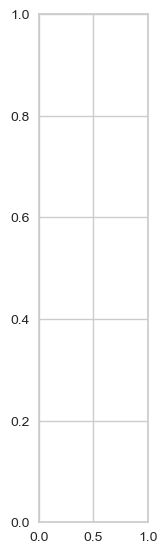

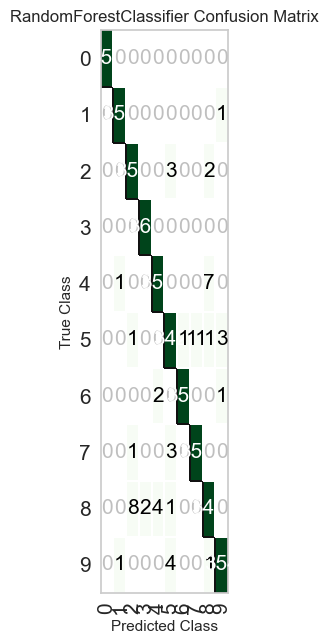

In [103]:
from pycaret.classification import setup, compare_models, create_model, plot_model
import pandas as pd

rf_model = create_model('rf')
print("Random Forest model created:", rf_model)

# Plot the confusion matrix for the Random Forest model
plot_model(rf_model, plot='confusion_matrix')


In [57]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
import warnings

warnings.filterwarnings('ignore')
# Ged rid of label for pycaret
X_train = X_train.drop(columns=['target'])
X_test = X_test.drop(columns=['target'])

def objective(trial):
    param = {
        'objective': 'multi:softprob',  # Use softprob for probability output
        'num_class': 10,
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
        ),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0, step=0.5),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    # cross-validation
    xgb_model = xgb.XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')

    return cv_accuracy.mean()

In [107]:
# sqlite:///120824_xgb-opt3.db

In [ ]:
# Activate for model optimization
import optuna
study_name = f'120824_xgb-opt4'
storage_name = f'sqlite:///{study_name}.db'
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True,)
study.optimize(objective, n_trials=1024)

In [73]:
# Get all trial results
trials_df = study.trials_dataframe()

# Rank models
trials_df['cv_accuracy'] = trials_df['value']
top_trials = trials_df.sort_values('cv_accuracy', ascending=False).head(5)
top_trials

# Extract the top 5 models
top_models = []
for index, row in top_trials.iterrows():
    params = study.trials[int(row['number'])].params
    params['objective'] = 'multi:multi:softprob'
    params['num_class'] = 10
    params['use_label_encoder'] = False
    params['eval_metric'] = 'mlogloss'
    params.pop('accuracy', None)
    
    # Create and fit the model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    top_models.append(('xgb_model_' + str(index), model))

top_models

[('xgb_model_733',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='mlogloss',
                feature_types=None, gamma=0.10029188550813316, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.5, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
                max_leaves=None, min_child_weight=2, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=None,
                n_jobs=None, num_class=10, num_parallel_tree=None, ...)),
 ('xgb_model_380',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

ensemble_xgb = VotingClassifier(estimators=top_models, n_jobs=-1)
ensemble_xgb.fit(X_train, y_train)


y_pred = ensemble_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"f1_score: {f1_score:.4f}")

# Show the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Testing Accuracy: 0.9887
Precision: 0.9888
Recall: 0.9887
f1_score: 0.9887
Confusion Matrix:
[[239   0   0   0   0   0   0   0   0   0]
 [  0 239   0   0   0   0   0   0   0   0]
 [  0   0 240   0   0   0   0   0   0   0]
 [  0   0   0 240   0   0   0   0   0   0]
 [  0   0   0   0 235   0   0   0   5   0]
 [  0   0   3   0   0 227   0   5   2   2]
 [  0   0   0   0   0   0 240   0   0   0]
 [  0   0   1   0   0   1   0 237   0   1]
 [  0   0   2   1   0   1   1   0 234   0]
 [  0   0   0   0   0   1   0   0   1 238]]


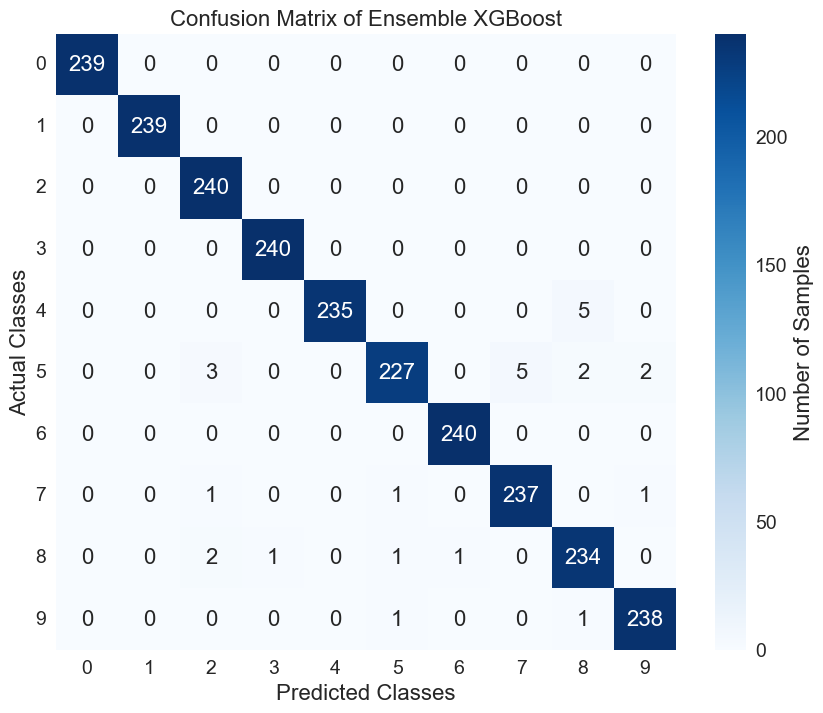

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
cf = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
ax.set_title('Confusion Matrix of Ensemble XGBoost', fontsize=16)
ax.set_xlabel('Predicted Classes', fontsize=16)
ax.set_ylabel('Actual Classes', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
cbar = cf.collections[0].colorbar
cbar.ax.tick_params(labelsize=14, pad=7)
cbar.set_label('Number of Samples', size=16)
plt.savefig('120824_xgb_confusion.png', dpi=300)
plt.show()

In [76]:
for name, model in top_models:
    print(f"Model Name: {name}")
    print("Parameters:")
    for param, value in model.get_params().items():
        print(f"  {param}: {value}")
    print("="*50)

Model Name: xgb_model_733
Parameters:
  objective: multi:softprob
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: mlogloss
  feature_types: None
  gamma: 0.10029188550813316
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.5
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 2
  max_leaves: None
  min_child_weight: 2
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: None
  n_jobs: None
  num_parallel_tree: None
  random_state: None
  reg_alpha: 0.32893658775047147
  reg_lambda: 0.15552804068487897
  sampling_method: None
  scale_pos_weight: 4.5
  subsample: 1.0
  tree_method: None
  validate_parameters: None
  verbosity: None
  num_class: 10
  use_label_encoder: False
Model Name: xgb_model_

In [78]:
xgboost_params = {
    "objective": "multi:softprob",
    "enable_categorical": False,
    "eval_metric": "mlogloss",
    "gamma": 0.10029188550813316,
    "learning_rate": 0.5,
    "max_depth": 2,
    "min_child_weight": 2,
    "missing": float("nan"),
    "reg_alpha": 0.32893658775047147,
    "reg_lambda": 0.15552804068487897,
    "scale_pos_weight": 4.5,
    "subsample": 1.0,
    "num_class": 10,
    "use_label_encoder": False
}

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"f1_score: {f1_score:.4f}")


Accuracy: 0.9996
Precision: 0.9888
Recall: 0.9887
f1_score: 0.9887


In [84]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.11615196096171625, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

In [100]:
explainer1 = shap.TreeExplainer(xgb_model)
shap_values1 = explainer1(shap_samples.reset_index(drop=True))
shap.summary_plot(shap_values1)

TypeError: only integer scalar arrays can be converted to a scalar index

Testing Accuracy: 0.9804
Precision: 0.9804
Recall: 0.9804
f1_score: 0.9803


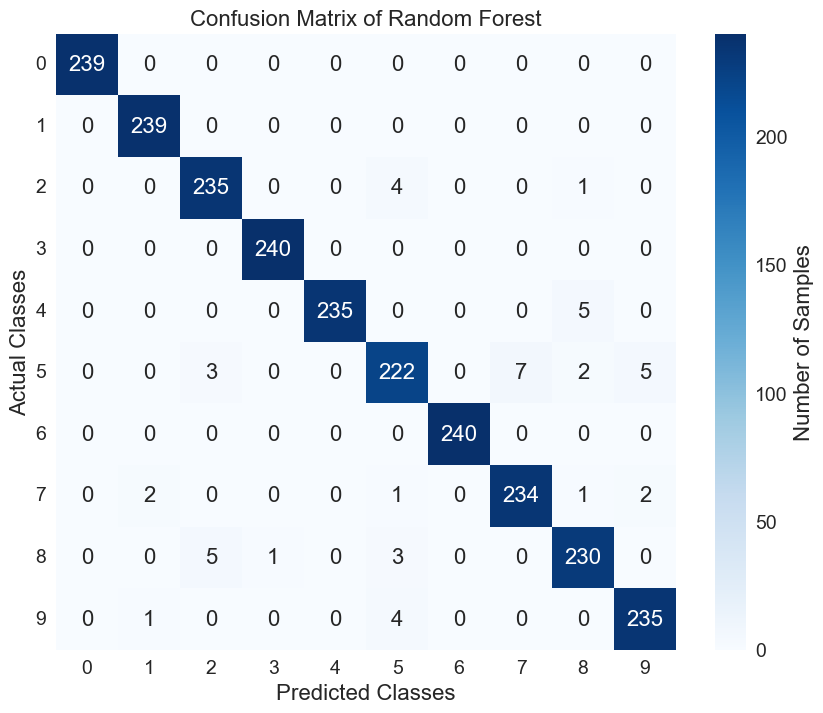

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"f1_score: {f1_score:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
cf = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
ax.set_title('Confusion Matrix of Random Forest', fontsize=16)
ax.set_xlabel('Predicted Classes', fontsize=16)
ax.set_ylabel('Actual Classes', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
cbar = cf.collections[0].colorbar
cbar.ax.tick_params(labelsize=14, pad=7)
cbar.set_label('Number of Samples', size=16)
plt.savefig('120824_tf_confusion.png', dpi=300)
plt.show()

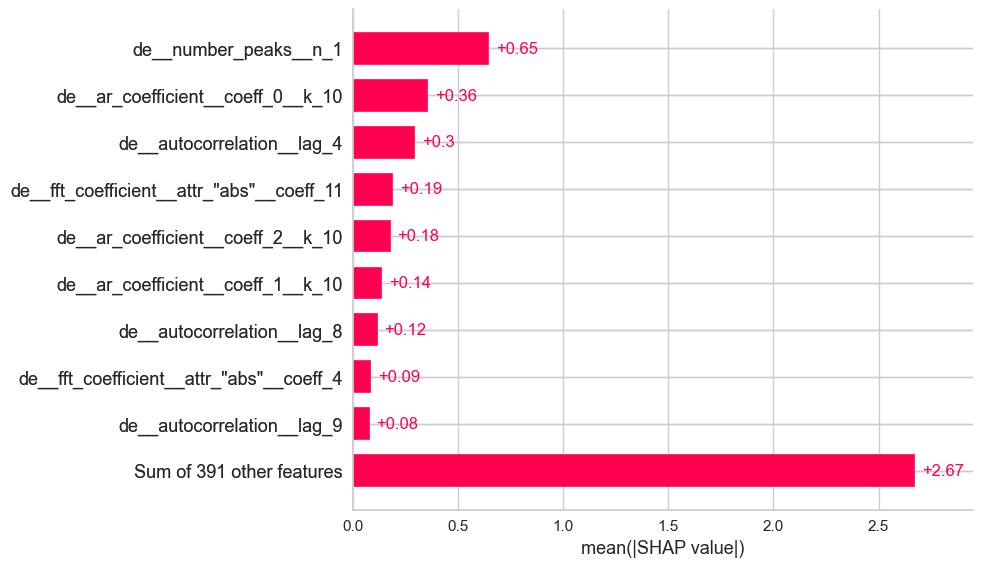

In [106]:
shap.plots.bar(shap_values.abs.mean(0))

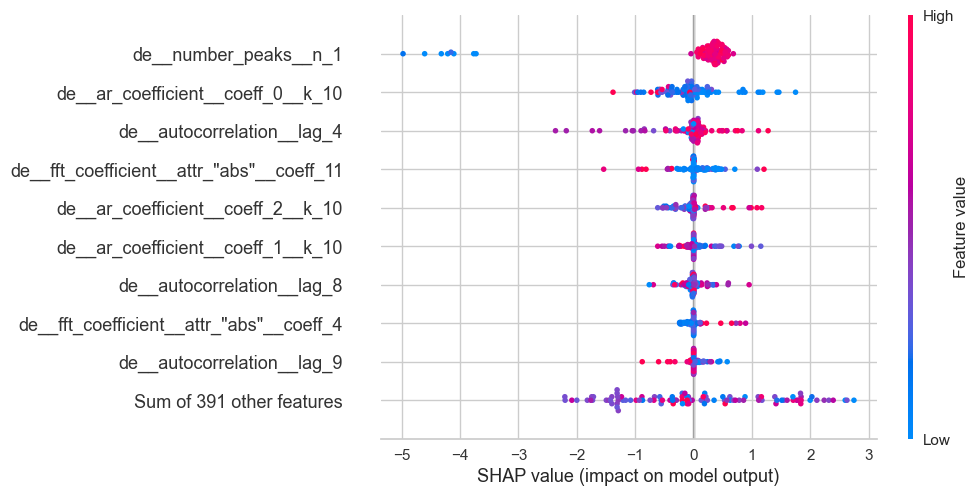

In [80]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), show=False)
plt.savefig('shap_xgb.png', dpi=300)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Support Vector Machine
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Evaluate models
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_pred))

print("Random Forest Performance:")
print(classification_report(y_test, rf_pred))

print("SVM Performance:")
print(classification_report(y_test, svm_pred))


C:\Users\s5575\miniconda3\envs\general\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       0.98      1.00      0.99       237
           2       0.88      0.90      0.89       249
           3       0.97      0.98      0.98       250
           4       0.95      0.96      0.96       265
           5       0.87      0.89      0.88       229
           6       0.97      0.96      0.97       251
           7       0.96      0.95      0.96       228
           8       0.86      0.83      0.85       218
           9       0.95      0.93      0.94       225

    accuracy                           0.94      2396
   macro avg       0.94      0.94      0.94      2396
weighted avg       0.94      0.94      0.94      2396

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       237
           2      

Model Evaluation Summary:

Logistic Regression:

Accuracy: 82%
Strengths: High recall and F1-score for some fault types like de_7_inner (1.00) and de_7_ball (0.94).
Weaknesses: Moderate performance for others, particularly de_14_* and de_21_*, where the recall is lower, indicating missed detections.

Random Forest:

Accuracy: 87%
Strengths: Overall better performance than logistic regression, with high recall for de_21_* and de_7_* fault types. Very good F1-scores across most classes.
Weaknesses: Lower recall for de_14_* and de_7_outer, indicating some difficulty detecting these faults, although still better than logistic regression.

SVM:

Accuracy: 68%
Strengths: High recall for some faults like de_7_inner (1.00) and de_21_ball (0.94).
Weaknesses: Poor overall performance, especially for de_14_* faults, with low recall (0.19) for de_14_ball.

Step 1: Hyperparameter Tuning for Random Forest

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score found: ", grid_search.best_score_)

# Evaluate the tuned model on the test set
best_rf_model = grid_search.best_estimator_
rf_tuned_pred = best_rf_model.predict(X_test)

# Print the classification report for the tuned model
from sklearn.metrics import classification_report
print("Tuned Random Forest Performance:")
print(classification_report(y_test, rf_tuned_pred, target_names=label_encoder.classes_))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy score found:  0.8811269028208641
Tuned Random Forest Performance:
              precision    recall  f1-score   support

  de_14_ball       1.00      0.89      0.94        36
 de_14_inner       0.69      0.71      0.70        35
 de_14_outer       0.72      0.92      0.80        36
  de_21_ball       0.97      0.94      0.96        36
 de_21_inner       0.92      0.94      0.93        36
 de_21_outer       0.73      0.77      0.75        35
   de_7_ball       0.97      0.83      0.90        36
  de_7_inner       1.00      1.00      1.00        36
  de_7_outer       0.92      0.94      0.93        35
   de_normal       0.94      0.81      0.87        36

    accuracy                           0.88       357
   macro avg       0.89      0.88      0.88       357
weighted avg       0.89      0.88      0

Best Hyperparameters:

max_depth: None (no limit on the depth of the tree)
min_samples_leaf: 1 (each leaf node can have as few as one sample)
min_samples_split: 10 (a node must have at least 10 samples to be split further)
n_estimators: 200 (number of trees in the forest)

Performance:

Overall accuracy: 88.1%
Precision, Recall, F1-Score:
Most fault types (e.g., de_14_ball, de_21_ball, de_7_inner, etc.) show high precision, recall, and F1-scores, indicating that the model performs well for these fault types.
Best F1-scores: The highest F1-scores are achieved for de_7_inner (1.00), which means this fault type is perfectly classified.
Performance across Fault Types: The performance is strong for most classes, though there is some variation. For instance, de_14_inner and de_21_outer have relatively lower precision and recall, indicating the model might have difficulty distinguishing these fault types or that they have more overlap with other classes.

Compare Model Performance

Let's compare the performance of the Tuned Random Forest model with Logistic Regression and SVM. Based on the results you previously shared, we have the following performance metrics for the three models:

Logistic Regression Performance:

Accuracy: 82%
Macro Avg Precision: 83%
Macro Avg Recall: 82%
Macro Avg F1-Score: 82%
Random Forest Performance (Tuned):

Accuracy: 88.1%
Macro Avg Precision: 89%
Macro Avg Recall: 88%
Macro Avg F1-Score: 88%
SVM Performance:

Accuracy: 68%
Macro Avg Precision: 73%
Macro Avg Recall: 68%
Macro Avg F1-Score: 65%

In [8]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



NameError: name 'X' is not defined

In [9]:
def extract_features(segments):
    features = []
    for segment in segments:
        # Extract exactly 8 features
        mean = np.mean(segment)
        std = np.std(segment)
        skewness = skew(segment)
        kurt = kurtosis(segment)
        
        # Peak features
        peak_to_peak = np.ptp(segment)
        max_val = np.max(segment)
        min_val = np.min(segment)
        
        # Frequency domain feature (FFT)
        fft_vals = np.abs(np.fft.fft(segment))
        fft_mean = np.mean(fft_vals)
        
        # Concatenate all features into a single vector
        features.append([mean, std, skewness, kurt, peak_to_peak, max_val, min_val, fft_mean])
    
    return np.array(features)

X_features = extract_features(segments)  # Reapply to ensure 8 features

print(X_features.shape) 


(1190, 8)


Error Analysis - Confusion Matrix

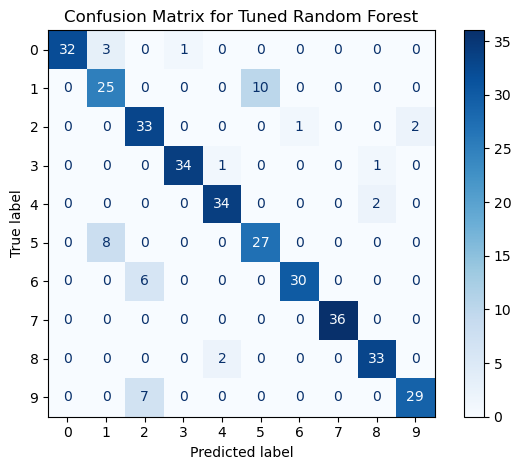

In [11]:

feature_names = [
    'Mean', 'Standard Deviation', 'Skewness', 'Kurtosis', 'Peak-to-Peak',
    'Max Value', 'Min Value', 'FFT Mean'
]

# Fit the model (if not already done)
model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Fit the model with your training data
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Tuned Random Forest")
plt.tight_layout()
plt.savefig('rf_confusion.png', dpi=300)
plt.show()



Implementation: CNN Model

In [9]:
!pip install tensorflow



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/cf/24/271e77c22724f370c24c705f394b8035b4d27e4c2c6339f3f45ab9b8258e/tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Obtaining dependency information for tensorflow-intel==2.18.0 from https://files.pythonhosted.org/packages/76/ad/fa6c508a15ff79cb5409294c293388e0999b7d480f84b65e4287277434fe/tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7

In [13]:
!pip install numpy==1.24.3
!pip install --upgrade tensorflow scipy gensim tables numba



  Obtaining dependency information for numpy==1.24.3 from https://files.pythonhosted.org/packages/f0/e8/1ea9adebdccaadfc208c7517e09f5145ed5a73069779ff436393085d47a2/numpy-1.24.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/14.8 MB 825.8 kB/s eta 0:00:18
    --------------------------------------- 0.4/14.8 MB 3.2 MB/s eta 0:00:05
   - -------------------------------------- 0.6/14.8 MB 4.1 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/14.8 MB 5.0 MB/s eta 0:00:03
   --- ------------------------------------ 1.4/14.8 MB 5.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.8/14.8 MB 6.0 MB/s eta 0:00:03
   ----- ---------------------------------- 2.2/14.8 MB 6.4 MB/s eta 0:00:02
   ------ --------------------------------- 2.6/14.8 MB 6.6 MB/s eta 0:00:02
   -------- -----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.


  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/ea/c2/5ecadc5fcccefaece775feadcd795060adf5c3b29a883bff0e678cfe89af/scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 217.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 281.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 361.0 kB/s eta 0:00:00
  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/f5/57/f2e6568dbf464a4b270954e5fa3dee4a4054d163a41c0e7bf0a34eb40f0f/gensim-4.3.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tables from https://files.pythonhosted.org/packages/1f/e3/3ee6b66263902eccadc4e0e23bca7fb480fd190904b7ce0bea4777b5b799/tables-3.10.1-cp311-cp311-win_amd64.whl.metada

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\~cipy\\fft\\_pocketfft\\pypocketfft.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X and y are your features and labels

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2, random_state=42)

# Normalize the data (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Add input layer (assuming X_train has 1000 features)
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer (for 10 classes)
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3352 - loss: 2.1368 - val_accuracy: 0.7101 - val_loss: 1.6208
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8458 - loss: 1.3197 - val_accuracy: 0.8361 - val_loss: 0.8256
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8728 - loss: 0.6181 - val_accuracy: 0.9496 - val_loss: 0.4194
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9570 - loss: 0.3046 - val_accuracy: 0.9538 - val_loss: 0.2532
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9556 - loss: 0.1917 - val_accuracy: 0.9580 - val_loss: 0.1743
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9723 - loss: 0.1277 - val_accuracy: 0.9622 - val_loss: 0.1312
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0948 - val_accuracy: 0.9622 - val_loss: 0.1073
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0839 - val_accuracy: 0.9622 - val_loss:

In [46]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0318 
Test Accuracy: 0.9873949289321899
Test Loss: 0.03240695968270302


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


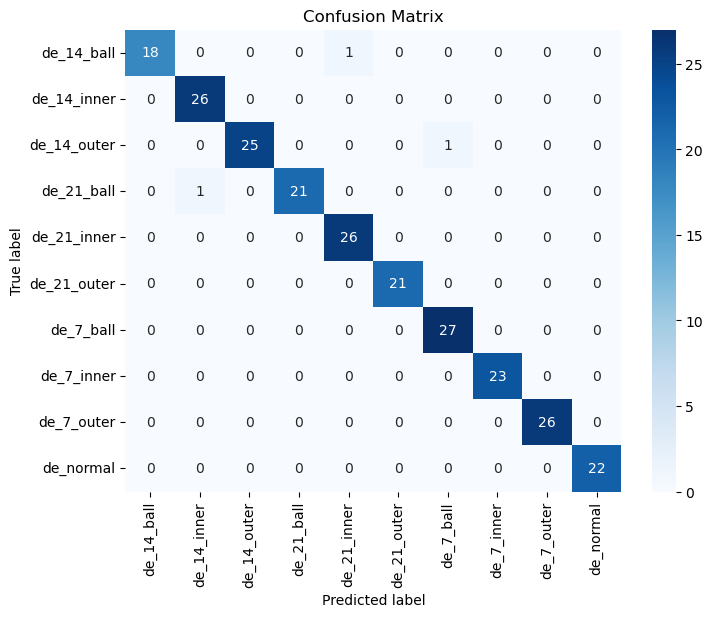

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.96      1.00      0.98        26
           2       1.00      0.96      0.98        26
           3       1.00      0.95      0.98        22
           4       0.96      1.00      0.98        26
           5       1.00      1.00      1.00        21
           6       0.96      1.00      0.98        27
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00        22

    accuracy                           0.99       238
   macro avg       0.99      0.99      0.99       238
weighted avg       0.99      0.99      0.99       238



In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes))


Hyperparameter Tuning

In [52]:
!pip install keras-tuner


  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --------------- ----------------------- 51.2/129.1 kB 871.5 kB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [54]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 6: Hyperparameter Tuning with Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # Tuning the number of layers and units in the dense layers
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    
    # Adding dropout layer for regularization
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second hidden layer
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    # Compiling the model with an optimizer chosen by the tuner
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Use Keras Tuner to search for the best hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Objective to optimize
    max_epochs=10,  # Maximum number of epochs per trial
    factor=3,  # Reduces the number of trials by a factor of 3 after each round
    directory='tuner_results',  # Directory to store tuner results
    project_name='hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best hyperparameters and the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.9873949289321899

Best val_accuracy So Far: 0.9915966391563416
Total elapsed time: 00h 01m 14s
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6419 - loss: 1.2781 - val_accuracy: 0.9286 - val_loss: 0.2384
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9523 - loss: 0.1539 - val_accuracy: 0.9664 - val_loss: 0.1258
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.0948 - val_accuracy: 0.9748 - val_loss: 0.0714
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9889 - loss: 0.0509 - val_accuracy: 0.9790 - val_loss: 0.0427
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9893 - loss: 0.0556 - val_accuracy: 0.9790 - val_loss: 0.0458
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9893 - loss: 0.0501 - val_accuracy: 0.9832 - val_loss: 0.0324
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9917 - loss: 0.0246 - val_accuracy: 0

Best validation accuracy: 99.16%
Final validation accuracy after training: 99.16%
Training accuracy: 99.48%
Validation loss: 0.0221
Training loss: 0.0265

In [55]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Step 7: Regularization (L2 + EarlyStopping)
def build_model_with_l2_regularization(hp):
    model = Sequential()
    
    # Adding a dense layer with L2 regularization
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu',
                    kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)))
    
    # Adding dropout layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second hidden layer with L2 regularization
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu',
                    kernel_regularizer=l2(0.01)))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    # Compiling the model with an optimizer chosen by the tuner
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Use Keras Tuner to search for the best hyperparameters with early stopping
tuner = kt.Hyperband(
    build_model_with_l2_regularization,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_results',
    project_name='hyperparameter_tuning_with_l2'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters and the best model
best_hps_l2 = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_l2 = tuner.hypermodel.build(best_hps_l2)

# Train the best model with early stopping and L2 regularization
best_model_l2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])


Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.6386554837226868

Best val_accuracy So Far: 0.9831932783126831
Total elapsed time: 00h 01m 24s
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6243 - loss: 3.6984 - val_accuracy: 0.9538 - val_loss: 0.9517
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 0.7926 - val_accuracy: 0.9454 - val_loss: 0.5756
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9646 - loss: 0.5175 - val_accuracy: 0.9580 - val_loss: 0.4593
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9649 - loss: 0.4768 - val_accuracy: 0.9664 - val_loss: 0.4072
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9744 - loss: 0.4093 - val_accuracy: 0.9706 - val_loss: 0.3670
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9669 - loss: 0.3851 - val_accuracy: 0.9748 - val_loss: 0.3676
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.3226 - val_accuracy: 0

Best validation accuracy achieved: 98.32%
Final validation accuracy: 95.80%
Training accuracy: 97.21%
Validation loss: 0.3341
Training loss: 0.2978

Model Evaluation on Test Set

Test Accuracy: 0.9916
Test Loss: 0.0221
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00        26
           2       1.00      0.96      0.98        26
           3       1.00      1.00      1.00        22
           4       0.96      1.00      0.98        26
           5       1.00      1.00      1.00        21
           6       0.96      1.00      0.98        27
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00        22

    accuracy                           0.99       238
   macro avg       0.99      0.99      0.99       238
weighted avg       0.99      0.99      0.99       238



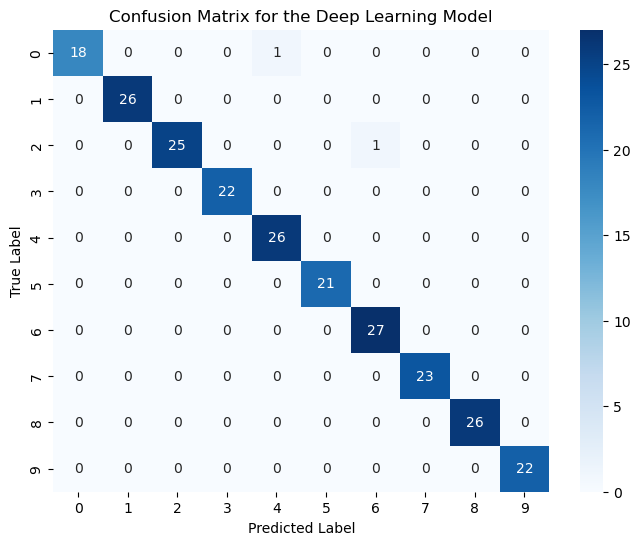

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get the predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Step 8.2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix for the Deep Learning Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


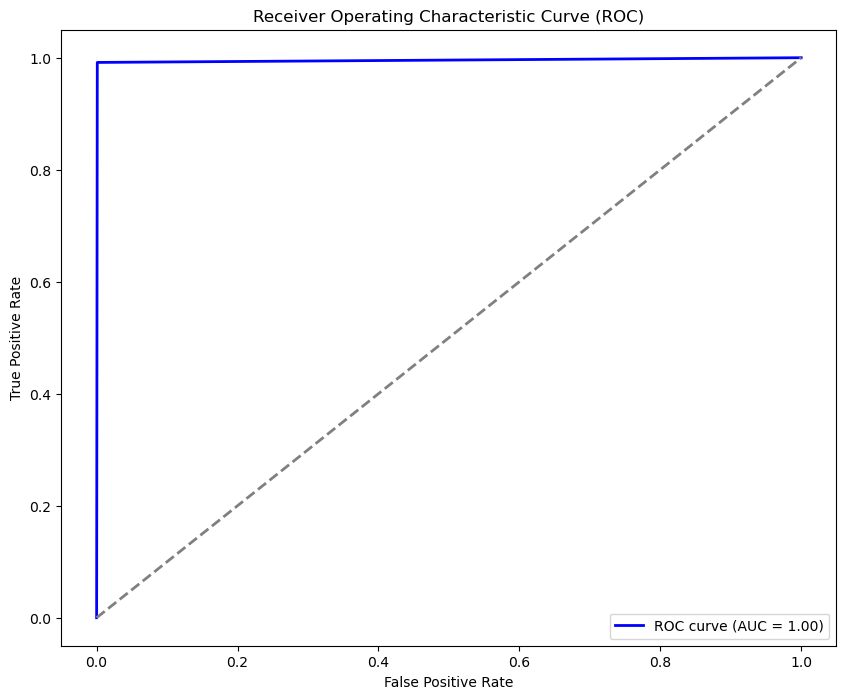

In [57]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the labels (for multi-class)
y_test_bin = label_binarize(y_test, classes=np.arange(10))  # Assuming 10 classes
y_pred_bin = label_binarize(y_pred_classes, classes=np.arange(10))

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc='best')
plt.show()
